# Pytorch: Supervised Learning
* Regression: TV Marketing `advertising.csv`
* Classification: AC Motor `vibration_10k.csv`

# 1. Linear Regression

In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('../../data/advertising.csv')
df.head()

,TV,Radio,Newspaper,Sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9


In [3]:
df.shape

(200, 4)

## 2.1 DataLoader 구축

In [4]:
X = df.drop('Sales', axis=1)
y = df['Sales']

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=0.8,
                                                    random_state=100)
X_train.shape, X_test.shape

((160, 3), (40, 3))

In [6]:
from torch.utils.data import TensorDataset, DataLoader

X_train = np.array(X_train).astype(np.float32)
y_train = np.array(y_train).astype(np.float32)

X_train_norm = (X_train - np.mean(X_train)) / np.std(X_train)
X_train_norm = torch.from_numpy(X_train_norm)
y_train = torch.from_numpy(y_train)

train_ds = TensorDataset(X_train_norm, y_train)

batch_size = 1
train_dl = DataLoader(train_ds,
                      batch_size,
                      shuffle=True)

In [7]:
X_train.dtype

dtype('float32')

## 1.2 Model Build

In [8]:
#learning_rate=0.001

import torch.nn as nn

model = nn.Sequential(
    nn.Linear(3, 10, bias=True), # input layer
    nn.ReLU(),
    nn.Linear(10, 10, bias=True), # layer 1, 2
    nn.ReLU(),
    nn.Linear(10, 10, bias=True), # layer 2,3
    nn.ReLU(),
    nn.Linear(10, 1, bias=True)) # layer3, output layer

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

## 1.3 Training

In [9]:
for epoch in range(100):
    for x_batch, y_batch in train_dl:
        pred = model(x_batch)
        
        loss = criterion(pred, y_batch)
        loss.backward()
        
        optimizer.step()
        optimizer.zero_grad()
        
    if epoch % 10 == 0:
        print(f'Epoch {epoch}: Loss {loss.item():.4f}')

c:\Users\parkm\anaconda3\envs\py_3_10_4\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0: Loss 0.7646
Epoch 10: Loss 0.0783
Epoch 20: Loss 0.3241
Epoch 30: Loss 0.1203
Epoch 40: Loss 1.0408
Epoch 50: Loss 2.0522
Epoch 60: Loss 0.2769
Epoch 70: Loss 0.7395
Epoch 80: Loss 0.8563
Epoch 90: Loss 0.2172


## 1.3 Prediction

In [10]:
X_test = np.array(X_test).astype(np.float32)
X_test_norm = (X_test - np.mean(X_train)) / np.std(X_train)
X_test_norm = torch.from_numpy(X_test_norm)

y_pred = model(X_test_norm).detach().numpy()

In [11]:
y_pred

array([[ 6.483747 ],
       [21.062063 ],
       [17.648355 ],
       [20.580399 ],
       [22.584463 ],
       [12.466888 ],
       [12.790702 ],
       [11.948318 ],
       [22.860739 ],
       [23.418303 ],
       [12.43521  ],
       [20.889814 ],
       [ 8.798817 ],
       [15.346502 ],
       [11.093117 ],
       [ 9.882514 ],
       [17.606546 ],
       [12.1241455],
       [18.684633 ],
       [12.793553 ],
       [16.81856  ],
       [10.776225 ],
       [22.974037 ],
       [18.570349 ],
       [15.221932 ],
       [24.557932 ],
       [20.50349  ],
       [11.283645 ],
       [21.251005 ],
       [15.667733 ],
       [12.913261 ],
       [ 9.808728 ],
       [11.089602 ],
       [14.692038 ],
       [ 8.784802 ],
       [14.973248 ],
       [ 9.7204075],
       [12.007073 ],
       [12.468901 ],
       [14.886777 ]], dtype=float32)

In [12]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def evaluate(y_test, y_pred):
    print('* MAE:', mean_absolute_error(y_test, y_pred))
    print('* RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))
    print('* R_Square:', r2_score(y_test, y_pred))

In [13]:
evaluate(y_test, y_pred)

* MAE: 0.5107033276557923
* RMSE: 0.6121735476715738
* R_Square: 0.9823651854299976


## 2. Pytorch: Classification

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [15]:
df = pd.read_csv('../../data/vibration_10k.csv', index_col=0)
df.head()

,Label_No,Label,Motor,WATT,AMP,AbsMax,AbsMean,P2P,RMS,Skewness,...,Shape,Impulse,1x,2x,3x,4x,1xB,2xB,3xB,4xB
Date,,,,,,,,,,,,,,,,,,,,,
2020-11-25 14:01:00,0.0,정상,L-CAHU-03R,11.0,22.0,0.054116,0.011482,0.092395,0.014053,-0.142563,...,1.223906,4.713012,0.021590,0.002832,0.000747,0.000476,0.000814,0.000405,0.000370,0.000278
2020-11-25 14:05:06,0.0,정상,L-CAHU-03R,11.0,22.0,0.051435,0.011649,0.088863,0.014295,-0.129078,...,1.227197,4.415492,0.021702,0.002757,0.000674,0.000674,0.000993,0.000407,0.000258,0.000224
2020-11-25 14:06:12,0.0,정상,L-CAHU-03R,11.0,22.0,0.046130,0.012619,0.085221,0.015276,-0.144933,...,1.210515,3.655473,0.021162,0.002808,0.000938,0.000420,0.000507,0.000395,0.000217,0.000176
2020-11-25 14:06:24,0.0,정상,L-CAHU-03R,11.0,22.0,0.053497,0.011505,0.093581,0.014059,-0.124687,...,1.221968,4.649777,0.021820,0.002246,0.000765,0.000583,0.000961,0.000614,0.000276,0.000347
2020-11-25 14:07:03,0.0,정상,L-PAHU-02S,37.0,71.1,0.073671,0.014504,0.123645,0.017763,-0.180152,...,1.224668,5.079276,0.000268,0.002277,0.000215,0.000851,0.000442,0.000774,0.000115,0.000496


In [16]:
df.shape

(10000, 22)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 2020-11-25 14:01:00 to 2021-01-31 17:55:22
Data columns (total 22 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Label_No  10000 non-null  float64
 1   Label     10000 non-null  object 
 2   Motor     10000 non-null  object 
 3   WATT      10000 non-null  float64
 4   AMP       10000 non-null  float64
 5   AbsMax    9988 non-null   float64
 6   AbsMean   10000 non-null  float64
 7   P2P       10000 non-null  float64
 8   RMS       10000 non-null  float64
 9   Skewness  10000 non-null  float64
 10  Kurtosis  10000 non-null  float64
 11  Crest     10000 non-null  float64
 12  Shape     10000 non-null  float64
 13  Impulse   10000 non-null  float64
 14  1x        10000 non-null  float64
 15  2x        10000 non-null  float64
 16  3x        10000 non-null  float64
 17  4x        10000 non-null  float64
 18  1xB       10000 non-null  float64
 19  2xB       10000 non-null  float64
 20  3

In [18]:
df['Label'].value_counts()

Label
정상        4612
벨트느슨함     1654
축정렬불량     1337
베어링불량     1243
회전체불평형    1154
Name: count, dtype: int64

In [19]:
df['Label_No'].nunique()

5

### 2.1 데이터 전처리

In [20]:
df.isnull().sum()

Label_No     0
Label        0
Motor        0
WATT         0
AMP          0
AbsMax      12
AbsMean      0
P2P          0
RMS          0
Skewness     0
Kurtosis     0
Crest        0
Shape        0
Impulse      0
1x           0
2x           0
3x           0
4x           0
1xB          0
2xB          0
3xB          0
4xB          0
dtype: int64

In [21]:
df['AbsMax'].fillna(df['AbsMax'].median(), inplace=True)
df.isna().sum()

Label_No    0
Label       0
Motor       0
WATT        0
AMP         0
AbsMax      0
AbsMean     0
P2P         0
RMS         0
Skewness    0
Kurtosis    0
Crest       0
Shape       0
Impulse     0
1x          0
2x          0
3x          0
4x          0
1xB         0
2xB         0
3xB         0
4xB         0
dtype: int64

### 2.2 Train/Test/Validation split

In [22]:
X = df.drop(['Label_No', 'Label', 'Motor'], axis=1).values.astype(np.float32)
y = df['Label_No'].values

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=0.9,
                                                    random_state=100)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                  train_size=0.9,
                                                  random_state=100)

X_train.shape, X_val.shape, X_test.shape

((8100, 19), (900, 19), (1000, 19))

In [23]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_val = sc.transform(X_val)
X_test = sc.transform(X_test)

### 2.3 Custom Dataset

In [24]:
class Dataset(Dataset):
    def __init__(self, X_train, y_train):
        self.X = torch.from_numpy(X_train)
        self.y = torch.from_numpy(y_train).type(torch.LongTensor) # 0,1,2,3,4
        self.len = self.X.shape[0]
        
    def __getitem__(self, index):
        return self.X[index], self.y[index]
    
    def __len__(self):
        return self.len

In [25]:
traindata = Dataset(X_train, y_train)
valdata = Dataset(X_val, y_val)
testdata = Dataset(X_test, y_test)

In [26]:
traindata[0]

(tensor([ 2.9360,  2.9223, -0.2450, -0.1864, -0.2465, -0.2145,  0.0336, -0.2420,
         -0.1951, -0.1683, -0.1787,  0.1850, -0.4115, -0.1707, -0.1647, -0.1426,
         -0.6645, -0.4022, -0.2380]),
 tensor(4))

In [27]:
BATCH_SIZE=64
EPOCHS=20
LEARNING_RATE=0.001
NUM_FEATURES=X_train.shape[1]
NUM_CLASSES=df['Label_No'].nunique()

### 2.4 DataLoader

In [28]:
train_loader = DataLoader(traindata,
                          batch_size=BATCH_SIZE,
                          shuffle=True)
val_loader = DataLoader(valdata,
                          batch_size=BATCH_SIZE,
                          shuffle=True)
test_loader = DataLoader(testdata,
                          batch_size=1)

### 2.5 Model Build

In [29]:
class MultiClassification(nn.Module):
    def __init__(self, num_feature, num_class):
        super(MultiClassification, self).__init__()
        
        self.layer_1 = nn.Linear(num_feature, 512)
        self.layer_2 = nn.Linear(512, 128)
        self.layer_3 = nn.Linear(128, 64)
        self.layer_out = nn.Linear(64, num_class)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.batchnorm1 = nn.BatchNorm1d(512)
        self.batchnorm2 = nn.BatchNorm1d(128)
        self.batchnorm3 = nn.BatchNorm1d(64)
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        
        x = self.layer_2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_3(x)
        x = self.batchnorm3(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_out(x) # softmax function을 적용x
        return x

In [30]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### 2.6 Loss Function & Optimizer

In [31]:
model = MultiClassification(NUM_FEATURES, NUM_CLASSES)
model.to(device)

criterion = nn.CrossEntropyLoss() #softmax 함수 포함
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
print(model)

MultiClassification(
  (layer_1): Linear(in_features=19, out_features=512, bias=True)
  (layer_2): Linear(in_features=512, out_features=128, bias=True)
  (layer_3): Linear(in_features=128, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=5, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (batchnorm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


### 2.7 Training

In [32]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim=1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim=1)
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    acc = torch.round(acc * 100)
    return acc

In [33]:
accuracy_stats = {'train':[], 'val':[]}
loss_stats = {'train':[], 'val':[]}

for epoch in tqdm(range(1, EPOCHS+1)):
    
    # train
    train_epoch_loss = 0
    train_epoch_acc = 0
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        
        y_train_pred = model(X_train_batch)
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = multi_acc(y_train_pred, y_train_batch)
        
        train_loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        
    # validation
    with torch.no_grad():
        val_epoch_loss = 0
        val_epoch_acc = 0
        
        model.eval() # validation 또는 test 시에 학습된 모델을 evaluation만 하겠다.
        
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)

            y_val_pred = model(X_val_batch)
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = multi_acc(y_val_pred, y_val_batch)

            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()
            
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
    
    print(f'Epoch {epoch+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.3f} | Val Loss: {val_epoch_loss/len(val_loader):.3f} \
    | Train Acc: {train_epoch_acc/len(train_loader):.3f} | Val Acc: {val_epoch_acc/len(val_loader):.3f}')
    

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.779 | Val Loss: 0.336     | Train Acc: 72.740 | Val Acc: 90.800
Epoch 002: | Train Loss: 0.226 | Val Loss: 0.138     | Train Acc: 91.780 | Val Acc: 95.200
Epoch 003: | Train Loss: 0.143 | Val Loss: 0.125     | Train Acc: 94.291 | Val Acc: 94.533
Epoch 004: | Train Loss: 0.125 | Val Loss: 0.084     | Train Acc: 94.787 | Val Acc: 96.800
Epoch 005: | Train Loss: 0.114 | Val Loss: 0.073     | Train Acc: 95.079 | Val Acc: 97.267
Epoch 006: | Train Loss: 0.094 | Val Loss: 0.070     | Train Acc: 96.102 | Val Acc: 97.733
Epoch 007: | Train Loss: 0.087 | Val Loss: 0.206     | Train Acc: 96.276 | Val Acc: 91.933
Epoch 008: | Train Loss: 0.118 | Val Loss: 0.077     | Train Acc: 95.370 | Val Acc: 96.867
Epoch 009: | Train Loss: 0.081 | Val Loss: 0.062     | Train Acc: 96.827 | Val Acc: 97.333
Epoch 010: | Train Loss: 0.086 | Val Loss: 0.062     | Train Acc: 96.378 | Val Acc: 97.667
Epoch 011: | Train Loss: 0.077 | Val Loss: 0.058     | Train Acc: 96.732 | Val Acc: 98.133

### 2.8 Loss/Accuracy Visualization

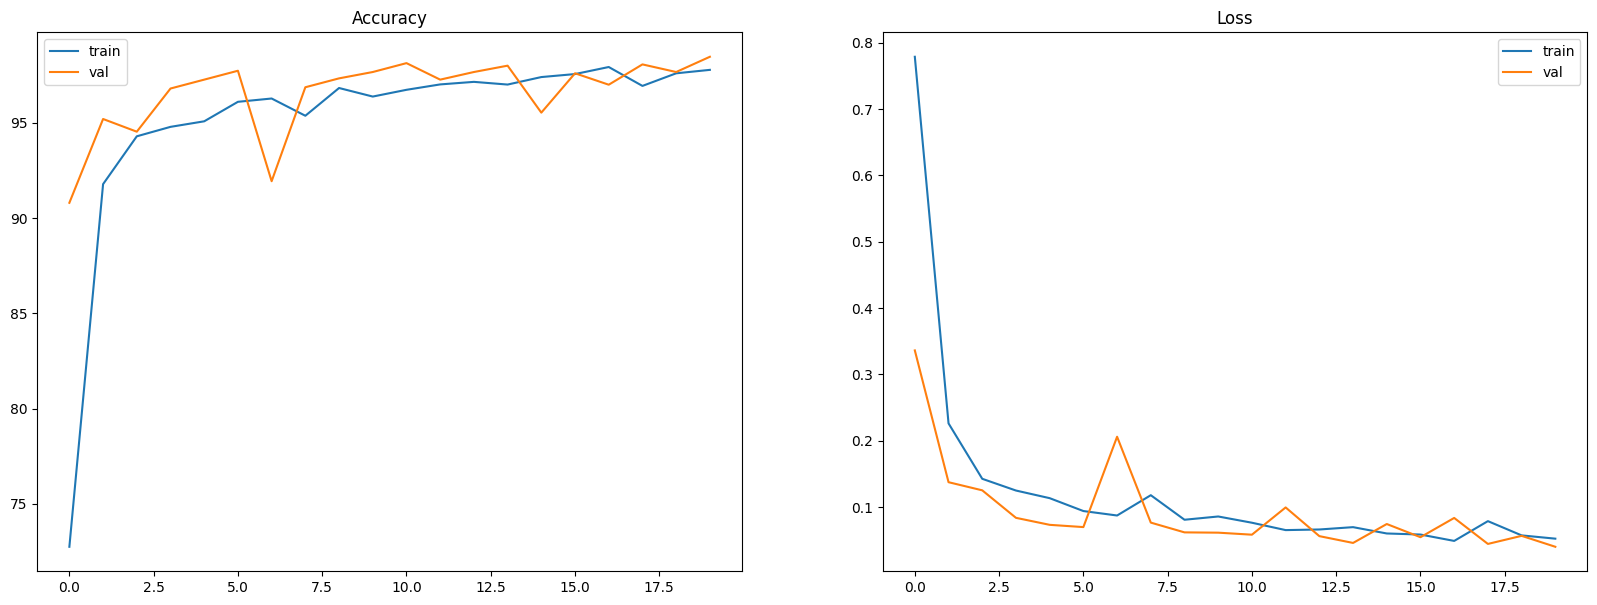

In [36]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 7))

ax[0].plot(accuracy_stats['train'], label='train')
ax[0].plot(accuracy_stats['val'], label='val')
ax[0].set_title('Accuracy')
ax[0].legend(loc='best')

ax[1].plot(loss_stats['train'], label='train')
ax[1].plot(loss_stats['val'], label='val')
ax[1].set_title('Loss')
ax[1].legend(loc='best')

### 2.9 Inference

In [37]:
y_pred_list = []
with torch.no_grad():
    model.eval()
    for X_batch, _ in test_loader:
        X_batch.to(device)
        y_test_pred = model(X_batch)
        _, y_pred_class = torch.max(y_test_pred, dim=1)
        y_pred_list.append(y_pred_class.cpu().numpy())

y_pred_list

[array([1], dtype=int64),
 array([4], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([1], dtype=int64),
 array([0], dtype=int64),
 array([3], dtype=int64),
 array([4], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([4], dtype=int64),
 array([1], dtype=int64),
 array([0], dtype=int64),
 array([3], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([2], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([1], dtype=int64),
 array([4], dtype=int64),
 array([2], dtype=int64),
 array([1], dtype=int64),
 array([1], dtype=int64),
 array([0], dtype=int64),
 array([2], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([4], dtype=int64),
 array([2], dtype=int64),
 array([2], 

In [38]:
print(classification_report(y_test, y_pred_list))

              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98       460
         1.0       0.98      0.98      0.98       123
         2.0       1.00      1.00      1.00       107
         3.0       0.96      0.98      0.97       131
         4.0       1.00      0.98      0.99       179

    accuracy                           0.98      1000
   macro avg       0.98      0.99      0.99      1000
weighted avg       0.99      0.98      0.99      1000



### 2.10 Save & Load Model
1. model 전체를 저장 : torch.save(model, path)
1. model dict 형식으로 저장 : torch.save(model.state_dict(), path)

In [39]:
torch.save(model, '../../model/acmotor.pth') # 확장자명은 *.pth 또는 *.pt

In [40]:
torch.save(model.state_dict(), '../../model/acmotor_dict.pth')

In [42]:
model_new = torch.load('../../model/acmotor.pth')

In [43]:
model_new

MultiClassification(
  (layer_1): Linear(in_features=19, out_features=512, bias=True)
  (layer_2): Linear(in_features=512, out_features=128, bias=True)
  (layer_3): Linear(in_features=128, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=5, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (batchnorm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)